In [1]:
%matplotlib nbagg
%load_ext line_profiler
%load_ext autoreload

In [2]:
import math
import time

import numpy as np
import scipy.constants as const
import matplotlib.pyplot as plt
import scipy.sparse
import sparse
import numba

In [3]:
from libertem import api
from libertem.executor.inline import InlineJobExecutor
from libertem.executor.base import AsyncAdapter
from libertem.udf.backend import set_use_cuda, set_use_cpu, get_backend
from libertem.udf.base import UDFRunner
from libertem.analysis.com import com_masks_factory, center_shifts, divergence, curl_2d, magnitude
from libertem.udf.masks import ApplyMasksUDF
from libertem.udf.stddev import StdDevUDF
from libertem.udf.sum import SumUDF
from libertem.common.container import MaskContainer
from libertem.masks import circular
from libertem.corrections.coordinates import flip_y, rotate_deg, identity
import libertem

In [4]:
from ptychography.reconstruction.ssb import SSB_UDF, generate_masks
from ptychography.reconstruction.ssb_lowmem import generate_masks as generate_lowmem
from ptychography.reconstruction.common import wavelength, get_shifted

In [5]:
from holatem.data import TCPBackend
from holatem.control import SimpleMerlinControl
from holatem.parser import MIBParser
from holatem.dataset import LiveDataSet

In [6]:
executor = InlineJobExecutor()
ctx = api.Context(executor=executor)
async_executor = AsyncAdapter(executor)
# ctx = api.Context()

In [7]:
host = '192.168.3.13'

In [8]:
ds_shape_sig = (256, 256)
ds_shape_nav = (128, 128)
# ds_shape_nav = (256, 256)
# Acceleration voltage in keV
U = 300
# U = 200
params = {
#     "dpix": 18e-12,
    "dpix": 12.7e-12,
#     "dpix": 287.5e-12,
    "center": (126, 123),
#     "center": (125, 129),
    "semiconv": 22.1346e-3,
#     "semiconv": 26e-3,
    "semiconv_pix": 31,
#     "semiconv_pix": 106,
    "dtype": np.float32,
    # "angle": 302.0,
    # "angle": 330.0,
    # applied right to left
    "transformation": rotate_deg(88) @ flip_y(),
#     "angle": 260,
    "cutoff": 15,
}

In [ ]:
mer = SimpleMerlinControl(host=host)

mer.connect()

mer.set('CONTINUOUSRW', 1)
mer.set('ACQUISITIONTIME', 300)  # ms
mer.set('NUMFRAMESTOACQUIRE',  1)
mer.set('NUMFRAMESPERTRIGGER', ds_shape_nav[-1])
mer.set('COUNTERDEPTH', 12)  # (1,6,12,24)
mer.set('TRIGGERSTART', 0)  # rising edge LVDS
mer.set('TRIGGERSTOP', 0)  # internal
mer.set('FILEENABLE', 0)  # saving
mer.set('FileFormat', 0)  # 0->binary mib, 1->not implemented, 2->raw binary mib

time.sleep(1.0)

mer.cmd('STARTACQUISITION')

mer.close()

In [ ]:
# grab a single frame
try:
    backend = TCPBackend(host=host)
    parser = MIBParser(backend, "float32")
    backend.connect()
    header = backend.read_acquisition_header()

    data = parser.get_frame()
finally:
    backend.close()

In [9]:
# ds = ctx.load("MIB", path=r'/cachedata/users/clausen/Ptycho01/20200518 121041/default.hdr')
# ds = ctx.load("MIB", path=r'/cachedata/users/clausen/20200514 162958/default.hdr')
# ds = ctx.load("MIB", path=r'/cachedata/users/clausen/Ptycho01/20200518 131720/default.hdr')
ds = ctx.load("MIB", path=r'/cachedata/users/clausen/Ptycho01/20200518 165148/default.hdr')
set_use_cpu(0)
std_res = ctx.run_udf(udf=SumUDF(), dataset=ds)
data = std_res["intensity"].data

/cachedata/users/weber/ptychography-venv/lib/python3.6/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  from numba.targets.imputils import impl_ret_borrowed, lower_constant
/cachedata/users/weber/ptychography-venv/lib/python3.6/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.targets.imputils', please update to use 'numba.core.imputils' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.targets.imputils import impl_ret_borrowed, lower_constant
/cachedata/users/weber/ptychography-venv/lib/python3.6/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'impl_ret_borrowed' requested from: '

<IPython.core.display.Javascript object>


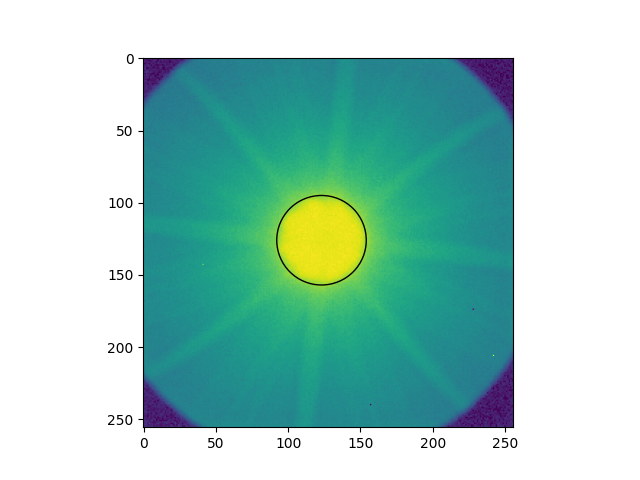

In [10]:
fig, axes = plt.subplots()
axes.imshow(np.log1p(data))
circ_a = plt.Circle(np.flip(params["center"]), params["semiconv_pix"], fill=False)
axes.add_artist(circ_a)

In [11]:
ds_sig = tuple(ds_shape_sig)
cy, cx = params["center"]
r = params["semiconv_pix"]

com_f = com_masks_factory(
    detector_y=ds_sig[0],
    detector_x=ds_sig[1],
    cy=cy,
    cx=cx,
    r=r*1.3,
)
adf = lambda: libertem.masks.ring(
    centerY=cy,
    centerX=cx,
    imageSizeY=ds_sig[0],
    imageSizeX=ds_sig[1],
    radius=r*2,
    radius_inner=r*1.3,
    antialiased=True
)

In [12]:
factories = com_f + [adf]

In [13]:
%autoreload
com_udf = ApplyMasksUDF(mask_factories=factories)

In [ ]:
mer = SimpleMerlinControl(host=host)

mer.connect()

mer.set('CONTINUOUSRW', 1)
mer.set('ACQUISITIONTIME', 0.555)  # ms
mer.set('NUMFRAMESTOACQUIRE',  int(np.prod(ds_shape_nav)))
mer.set('NUMFRAMESPERTRIGGER', ds_shape_nav[-1])
mer.set('COUNTERDEPTH', 6)  # (1,6,12,24)
mer.set('TRIGGERSTART', 3)  # rising edge LVDS
mer.set('TRIGGERSTOP', 0)  # internal
mer.set('FILEENABLE', 1)  # saving
mer.set('FileFormat', 0)  # 0->binary mib, 1->not implemented, 2->raw binary mib

time.sleep(1.0)

mer.cmd('STARTACQUISITION')

mer.close()

<IPython.core.display.Javascript object>


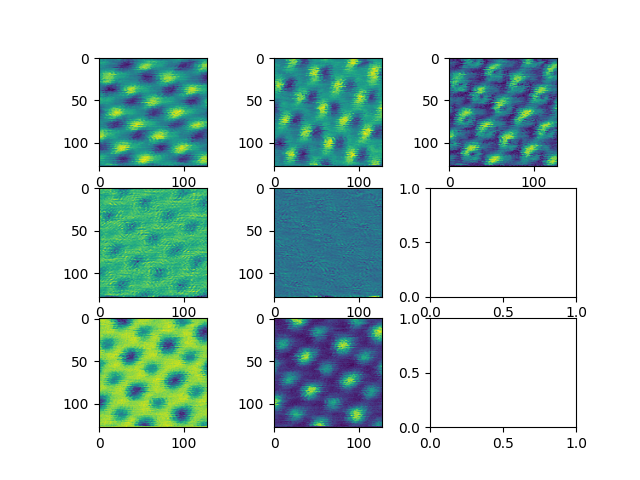

In [14]:
%autoreload

fig, axes= plt.subplots(3, 3)
set_use_cuda(0)

# cos_angle = np.cos(np.pi/180*0) # to be adjusted
# sin_angle = np.sin(np.pi/180*0) # to be adjusted


im_obj = dict()
for i in range(3):
    for j in range(3):
        im_obj[(i, j)] = None

try:
#     ds = LiveDataSet(scan_size=ds_shape_nav, backend=TCPBackend(host=host), frames_per_partition=1024)
#     ds = LiveDataSet(scan_size=ds_shape_nav, backend=TCPBackend(host='localhost'), frames_per_partition=123)
#     ds = ds.initialize(executor=executor)
#     ds.wait_for_acquisition()
#     ds = ctx.load("MIB", path=r'/cachedata/users/clausen/Ptycho01/20200518 131720/default.hdr')
    ds = ctx.load("MIB", path=r'/cachedata/users/clausen/Ptycho01/20200518 165148/default.hdr')
#     ds = ctx.load("MIB", path=r'/cachedata/users/clausen/20200514 162958/default.hdr')
    udfres_iter = UDFRunner([com_udf]).run_for_dataset_async(dataset=ds, executor=async_executor, cancel_id="whatever")
    async for udf_results in udfres_iter:
        res = udf_results[0]['intensity'].data

        y_centers, x_centers = params["transformation"] @ np.array(center_shifts(
            res[..., 0], res[..., 1], res[..., 2], cy, cx
        )).reshape((2, -1))
        y_centers = y_centers.reshape(ds.shape.nav)
        x_centers = x_centers.reshape(ds.shape.nav)

        data_items = {
            (0, 0): y_centers,
            (0, 1): x_centers,
            (0, 2): magnitude(y_centers, x_centers),
            (1, 0): divergence(y_centers, x_centers),
            (1, 1): curl_2d(y_centers, x_centers),
            (2, 0): res[..., 0], # bright field
            (2, 1): res[..., 3], # annular dark field
        }
        for key, data in data_items.items():
            if im_obj[key] is None:
                im_obj[key] = axes[key].imshow(data)
            else:
                im_obj[key].set_data(data)
            i_o = im_obj[key]
            i_o.autoscale()
    #         i_o.norm.vmin = np.min(data[data!=0])
    #         i_o.norm.vmax = np.max(max(1, np.max(data[data!=0])))
            i_o.changed()
        fig.canvas.draw()
finally:
    try:
        ds._backend.close()
    except AttributeError:
        pass

In [15]:
def curl_plot(udf_results):
    def curl_sum(res, angle):
        transform = rotate_deg(angle) @ flip_y()
        shape = res.shape[:-1]
        y_centers, x_centers = transform @ np.array(center_shifts(
            res[..., 0], res[..., 1], res[..., 2], cy, cx
        )).reshape((2, -1))
        
        y_centers = y_centers.reshape(shape)
        x_centers = x_centers.reshape(shape)
        
        return np.sum(np.abs(curl_2d(y_centers, x_centers)))
    res = udf_results['intensity'].data
    angle = np.linspace(0, 360, 360, endpoint=False)
    return np.array([curl_sum(res, a) for a in angle])

<IPython.core.display.Javascript object>


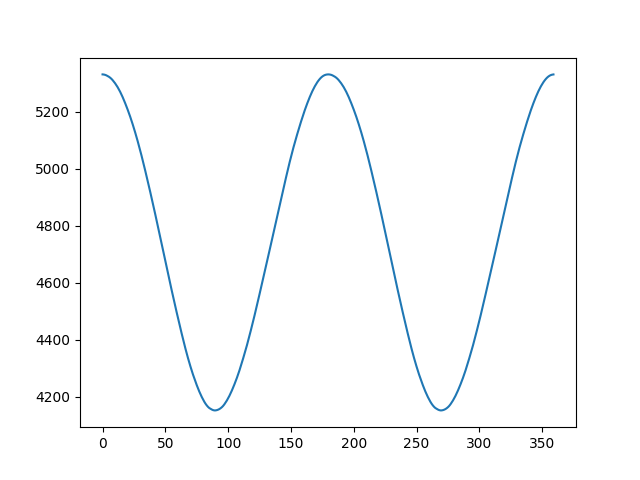

In [17]:
fig, axes = plt.subplots()
plt.plot(curl_plot(udf_results[0]))

<IPython.core.display.Javascript object>


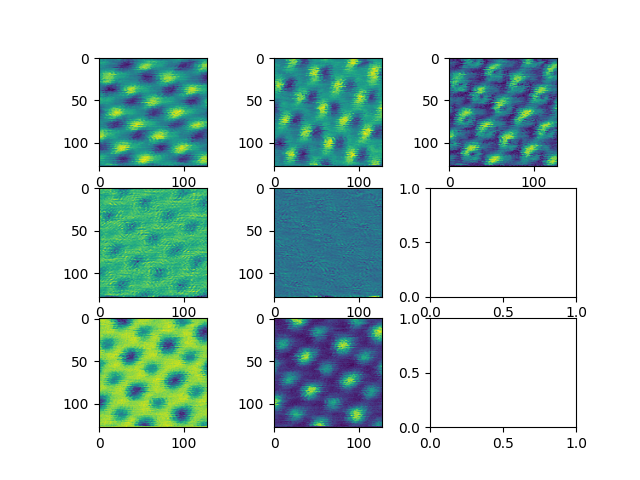

In [19]:
fig, axes= plt.subplots(3, 3)

im_obj = dict()
for i in range(3):
    for j in range(3):
        im_obj[(i, j)] = None

res = udf_results[0]['intensity'].data
shape = res.shape[:-1]
y_centers, x_centers = params["transformation"] @ np.array(center_shifts(
    res[..., 0], res[..., 1], res[..., 2], cy, cx
)).reshape((2, -1))
y_centers = y_centers.reshape(shape)
x_centers = x_centers.reshape(shape)

data_items = {
    (0, 0): y_centers,
    (0, 1): x_centers,
    (0, 2): magnitude(y_centers, x_centers),
    (1, 0): divergence(y_centers, x_centers),
    (1, 1): curl_2d(y_centers, x_centers),
    (2, 0): res[..., 0], # bright field
    (2, 1): res[..., 3], # annular dark field
}
for key, data in data_items.items():
    im_obj[key] = axes[key].imshow(data)


## Mask generation

In [52]:
%%time
%autoreload

set_use_cuda(0)

# masks = generate_masks(
masks = generate_lowmem(  # faster version from the lowmem development
    **params,
    mask_shape=ds_shape_sig,
    wavelength=wavelength(U),
    reconstruct_shape=ds_shape_nav,
)

mask_container = MaskContainer(
    mask_factories=lambda: masks, dtype=masks.dtype,
    use_sparse='scipy.sparse.csc', count=masks.shape[0], backend=get_backend()
)

Mask factory size 72610774 larger than warning limit 1048576, may be inefficient


CPU times: user 5.4 s, sys: 46.2 ms, total: 5.45 s
Wall time: 5.44 s


In [53]:
%autoreload
ssb_udf = SSB_UDF(
    U=U, **params,
    mask_container=mask_container,
)

In [56]:
%%time
ctx.run_udf(udf=ssb_udf, dataset=ds)
# Wall time: 25.2 s 'scipy.sparse.csr' transposed
# Wall time: 4.26 s 'scipy.sparse.csc' transposed
# Wall time: 5.3 s 'scipy.sparse.csc' not transposed
# Wall time: 3.84 s 'scipy.sparse.csr' not transposed
# Wall time: 3.77 s 'scipy.sparse.csc' transposed

CPU times: user 3.54 s, sys: 237 ms, total: 3.78 s
Wall time: 3.77 s


{'pixels': <BufferWrapper kind=single dtype=complex64 extra_shape=(128, 128)>}

## Start continuous acquisition

In [ ]:
mer = SimpleMerlinControl(host=host)

mer.connect()

mer.set('CONTINUOUSRW', 1)
mer.set('ACQUISITIONTIME', 1)  # ms
# mer.set('NUMFRAMESTOACQUIRE',  int(np.prod(ds_shape_nav)))
mer.set('NUMFRAMESTOACQUIRE',  0)
mer.set('NUMFRAMESPERTRIGGER', ds_shape_nav[-1])
mer.set('COUNTERDEPTH', 6)  # (1,6,12,24)
mer.set('TRIGGERSTART', 3)  # rising edge LVDS
mer.set('TRIGGERSTOP', 0)  # internal
mer.set('FILEENABLE', 0)  # saving
mer.set('FileFormat', 2)  # 0->binary mib, 1->not implemented, 2->raw binary mib

time.sleep(1.0)

mer.cmd('STARTACQUISITION')

mer.close()

<IPython.core.display.Javascript object>


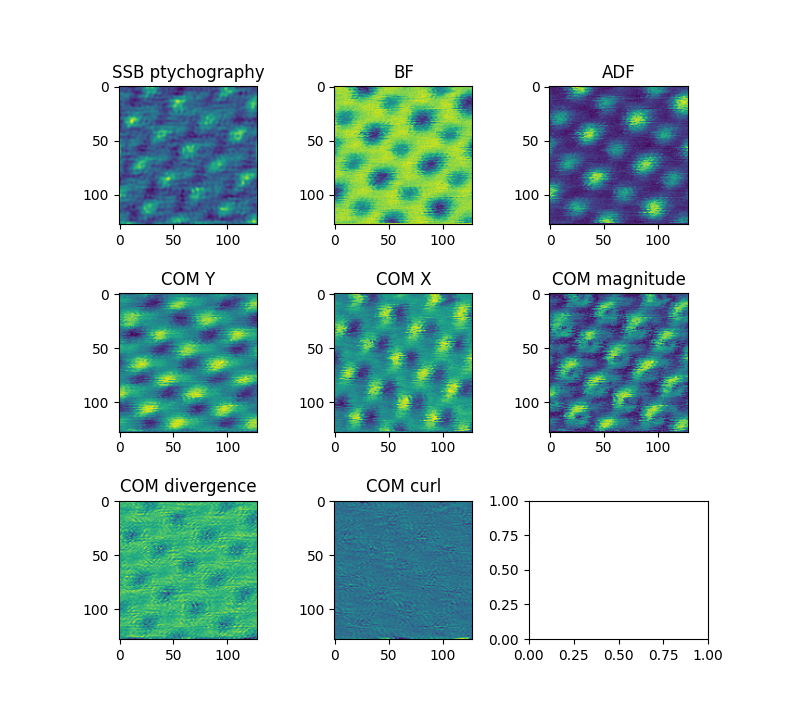

In [59]:
fig, axes = plt.subplots(3, 3, gridspec_kw={"hspace": 0.5})

z = np.zeros(ds_shape_nav)

titles = {
    (0, 0): "SSB ptychography",
    (0, 1): "BF",
    (0, 2): "ADF", # annular dark field
    (1, 0): "COM Y",
    (1, 1): "COM X",
    (1, 2): "COM magnitude",
    (2, 0): "COM divergence",
    (2, 1): "COM curl",
}

im_obj = {}

for key, title in titles.items():
    im_obj[key] = axes[key].imshow(z)
    axes[key].set_title(title)

In [61]:
try:
#     ds = LiveDataSet(scan_size=ds_shape_nav, backend=TCPBackend(host=host), frames_per_partition=1024)
    #ds = LiveDataSet(scan_size=ds_shape_nav, backend=TCPBackend(host='localhost'), frames_per_partition=1024)
#     ds = ds.initialize(executor=executor)
#     ds.wait_for_acquisition()
#     ds = ctx.load("MIB", path=r'/cachedata/users/clausen/20200514 162958/default.hdr')
#     ds = ctx.load("MIB", path=r'/cachedata/users/clausen/Ptycho01/20200518 131720/default.hdr')
    ds = ctx.load("MIB", path=r'/cachedata/users/clausen/Ptycho01/20200518 165148/default.hdr')
#     while True:
    udfres_iter = UDFRunner([ssb_udf, com_udf]).run_for_dataset_async(dataset=ds, executor=async_executor, cancel_id="whatever")
    
    for key in titles.keys():
        im_obj[key].set_data(z)
    
    async for udf_results in udfres_iter:
        res = udf_results[1]["intensity"].data
        y_centers, x_centers = params["transformation"] @ np.array(center_shifts(
            res[..., 0], res[..., 1], res[..., 2], *params["center"]
        )).reshape((2, -1))
        y_centers = y_centers.reshape(ds_shape_nav)
        x_centers = x_centers.reshape(ds_shape_nav)
        
        data_items = {
            (0, 0): np.angle(np.fft.ifft2(udf_results[0]["pixels"])),
            (0, 1): res[..., 0], # bright field
            (0, 2): res[..., 3], # annular dark field
            (1, 0): y_centers,
            (1, 1): x_centers,
            (1, 2): magnitude(y_centers, x_centers),
            (2, 0): divergence(y_centers, x_centers),
            (2, 1): curl_2d(y_centers, x_centers),

        }
#         adf = udf_results["adf"].data
        for key, data_item in data_items.items():
            i_o = im_obj[key]
            i_o.set_data(data_item)
            i_o.autoscale()
            i_o.norm.vmin = np.min(data_item[data_item!=0])
            i_o.norm.vmax = np.max(np.max(data_item[data_item!=0]))
            i_o.changed()
        fig.canvas.draw()
finally:
    try:
        ds._backend.close()
    except AttributeError:
        pass

<IPython.core.display.Javascript object>


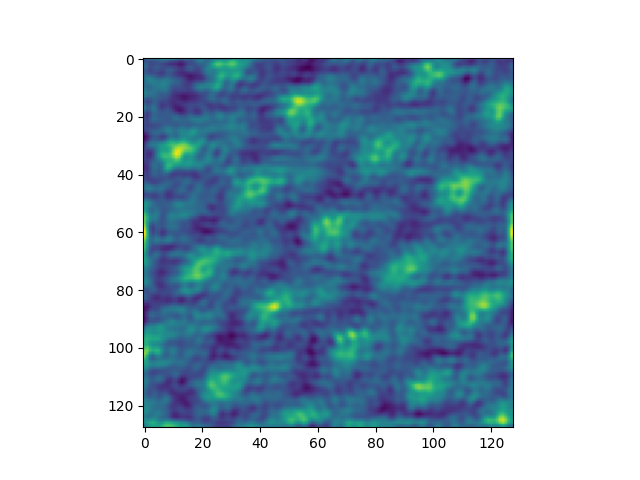

In [36]:
fig, axes = plt.subplots()
axes.imshow(np.angle(np.fft.ifft2(udf_results[0]["pixels"])))